# An Implenmentiaon of COVID-19 Lung CT Lesion Segmentation Challenge - 2020 

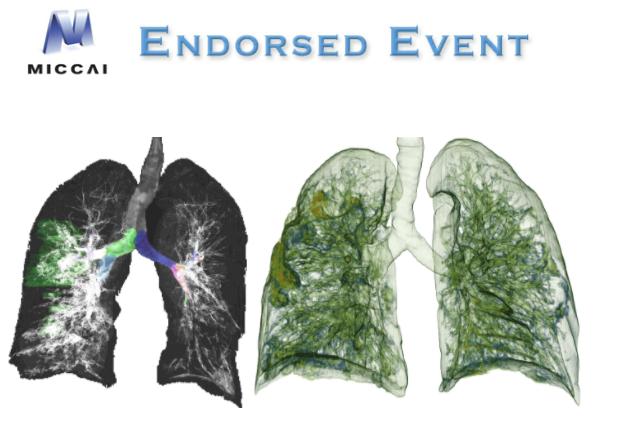

https://covid-segmentation.grand-challenge.org/COVID-19-20/

**Background**

The COVID-19 pandemic has had a devastating impact on the health of individuals worldwide. The manifestation of the viral infection in the lung has been one of the earliest indicators of disease and may play an important role in the clinical management of patients. Ground glass opacities are the most common finding in COVID-19 lung computed tomography (CT) images, usually multifocal, bilateral and peripheral. However, the type, the size and distribution of the lung lesions may vary with the age of the patients and the severity or stage of the disease.


The data are from above website after registeration. I saved the data to my google drive first.

In [ ]:
#conneting google drive so that we can use the data of COVID-19
from google.colab import drive
drive.mount('/gdrive') ## mount drive
#The following codes only run once, then the initial data will be extracted into google drive
#!unzip '/gdrive/My Drive/COVID-19-20.zip' -d '/gdrive/My Drive/COVID-19-20/'


Mounted at /gdrive


In [ ]:
!pip install -U segmentation-models 
!pip install imgaug==0.2.9
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


     |████████████████████████████████| 50 kB 5.8 MB/s 
Version:  2.7.0
Eager mode:  True
GPU is available


In [ ]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# from keras.models import Model, load_model
# from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
# from keras.layers.core import Lambda, RepeatVector, Reshape
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
# from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
# from keras.layers.merge import concatenate, add
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
# from keras.optimizers import Adam

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
import segmentation_models as sm
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif
import shutil
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
from skimage import measure
from skimage import morphology


Segmentation Models: using `keras` framework.
  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-01fg9pbl
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-01fg9pbl
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.0-py3-none-any.whl size=6270 sha256=5edd9e9f99bc5f2c3ad9a5d5f51d5c3b388b64f9b5ab973b27387bba67d18e5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wdapxvx/wheels/4a/8c/d1/b228c3b67231f7459e8f70d73f4dadaf65cd90692d41f43e88
Successfully built gif-your-nifti


In [ ]:
root='/gdrive/My Drive/COVID-19-20/COVID-19-20_v2/'

In [ ]:
data = pd.read_excel('/gdrive/My Drive/COVID-19-20/COVID-19-20_v2/COVID-19-20_TrainValidation.xlsx')
print(data.size)
data.head(5)


199


FILENAME
0    volume-covid19-A-0391
1  volume-covid19-A-0383_1
2    volume-covid19-A-0338
3    volume-covid19-A-0623
4    volume-covid19-A-0559

In [ ]:
ct_scan_path=[]
ct_scan_path=np.array(data['FILENAME'])
ct_scan_path[0]

'volume-covid19-A-0391'

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    plt.rcParams["axes.grid"] = False
    fig = plt.figure(figsize=(20,15))
    gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1, 1.5])

    #  Varying density along a streamline
    ax0 = fig.add_subplot(gs[0, 0])
    flair = ax0.imshow(array_list[0], cmap='bone')
    ax0.set_title("original", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(flair)
    #  Varying density along a streamline
    ax1 = fig.add_subplot(gs[0, 1])
    t1 = ax1.imshow(array_list[1], cmap='bone')
    ax1.set_title("mask", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(t1)    
    #  Varying density along a streamline
    ax2 = fig.add_subplot(gs[0, 2])
    t2 = ax2.imshow(array_list[0], cmap='bone')
    t3 = ax2.imshow(array_list[1], alpha=0.5, cmap=color_map)   

    ax2.set_title("original+mask", fontsize=18, weight='bold', y=-0.2)
    fig.colorbar(t2)    
    # plt.show()


In [ ]:
def enhanced_img(test_img,visualize):
  test_img = test_img*255
  test_img = np.uint8(test_img)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)     # parameter passed must be of dtype uint8

  if(visualize==1):
    plt.rcParams["axes.grid"] = False    
    fig = plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    org=plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")
    plt.grid(False)
    fig.colorbar(org)
  
    plt.subplot(1,2,2)
    enhance=plt.imshow(clahe_image, cmap='bone')
    plt.title("Enhanced CT-Scan")
    plt.grid(False)
    fig.colorbar(enhance)
  return clahe_image   

In [ ]:

img_size=512


In [ ]:
def read_nii_demo(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]

    return array

In [ ]:
def read_nii(filepath,img_arr,string):

    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    # print(array.shape)
    slices = array.shape[2]
    # get the slices b/w 25% and 75%
    array = array[:,:,round(slices*0.25):round(slices*0.75)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    
    for img_no in range(0, array.shape[0]):
      if (img_size !=array.shape[0]) or (img_size !=array.shape[1]):
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)  #resizing all images to the same dimensions
      else:
        img= array[img_no]
      # Normalising the Image
      if string == "cts" :
        # img=make_lungmask(img)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin+1e-5)/(xmax - xmin+1e-5)        
        img = enhanced_img(img, visualize= 0)
      if string == "infections":
        xmax, xmin = img.max(), img.min()
        img = (img - xmin+1e-5)/(xmax - xmin+1e-5)        
        img = np.uint8(img*255)        
      img_arr.append(img)

In [ ]:
index=1
train_root='/gdrive/My Drive/COVID-19-20/COVID-19-20_v2/Train/'
suffix='_ct.nii.gz'
mask='_seg.nii.gz'
sample_ct=read_nii_demo(train_root+ct_scan_path[index]+suffix)
sample_infe=read_nii_demo(train_root+ct_scan_path[index]+mask)

In [ ]:
print(ct_scan_path.shape)
print(sample_ct.shape)
print(sample_infe.shape)

(199,)
(512, 512, 54)
(512, 512, 54)


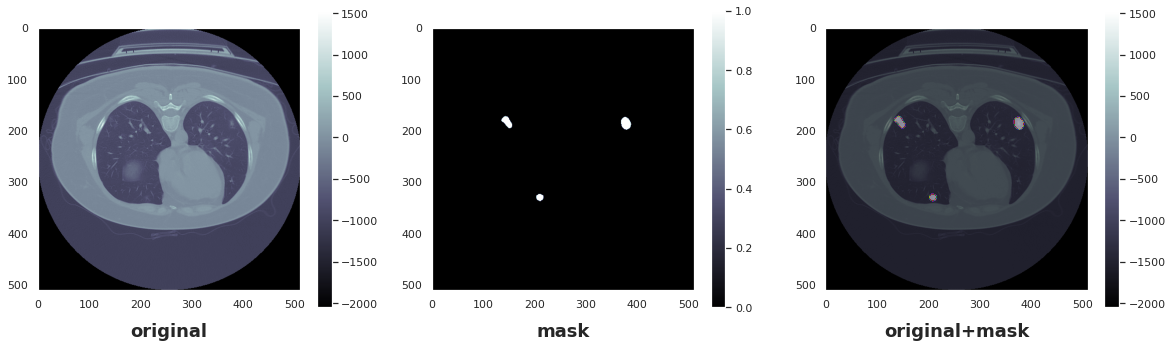

In [ ]:
plot_sample([sample_ct[...,20],  sample_infe[...,20]])

In [ ]:
shutil.copy2(train_root+ct_scan_path[index]+suffix, root+ct_scan_path[index]+suffix)


'/gdrive/My Drive/COVID-19-20/COVID-19-20_v2/volume-covid19-A-0383_1_ct.nii.gz'

In [ ]:
# the following codes will generate a animation of the codes
def niitogif(path):
  tmpimg=nib.load(path)

  fdata=tmpimg.get_fdata()
  xmax, xmin = fdata.max(), fdata.min()
  fdata = (fdata - xmin)*255 / (xmax - xmin)
  data = np.round(fdata.astype(np.uint8))
  tmpimg.header.set_data_dtype(np.uint8)
  tmpimg = nib.Nifti1Image(data, header=tmpimg.header, affine=tmpimg.affine)
  nib.save(tmpimg, path)
  gif2nif.write_gif_normal(path,size=0.5)

In [ ]:
# niitogif(root+ct_scan_path[index]+suffix)

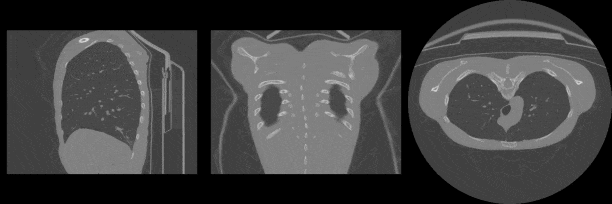

In [ ]:
# normalising the sample CT_Scan and sample lung 
sample_ct=(sample_ct-sample_ct.min())/(sample_ct.max()-sample_ct.min())



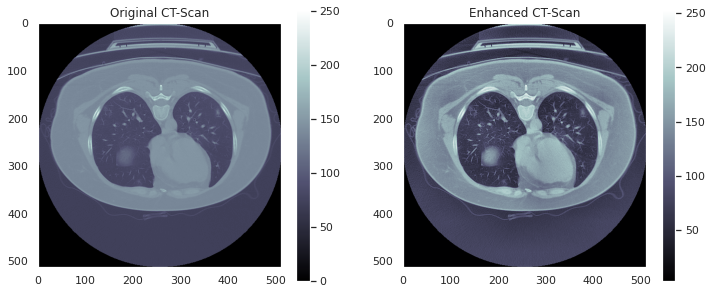

In [ ]:
#sample_ct_grey=cv2.cvtColor(sample_ct[...,120],cv2.COLOR_BGR2GRAY)
img=enhanced_img(sample_ct[...,20],visualize=1)

In [ ]:
cts = []
infections = []
for i in range(0, data.size):
  read_nii(train_root+data.loc[i,'FILENAME']+suffix, cts, 'cts') 
  read_nii(train_root+data.loc[i,'FILENAME']+mask, infections, 'infections')

(512, 512) (512, 512)


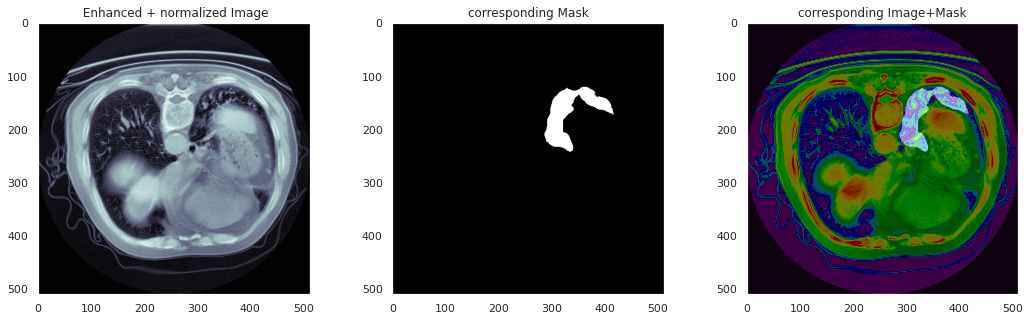

In [ ]:
ind = 100
# rcParams['figure.figsize'] = 10,10
fig = plt.figure(figsize=(18,5)) 
plt.subplot(1, 3, 1)
plt.rc('grid', color='b', linestyle='solid')
org=plt.imshow(cts[ind], cmap='bone')
# fig.colorbar(org)
plt.title(" Enhanced + normalized Image")
plt.grid(False)

plt.subplot(1, 3, 2)
plt.imshow(infections[ind], cmap='bone')
plt.title("corresponding Mask")
plt.grid(False)

plt.subplot(1, 3, 3)
plt.imshow(infections[ind], cmap='bone')
plt.imshow(cts[ind], alpha=0.5, cmap='nipy_spectral') 
plt.title("corresponding Image+Mask")
plt.grid(False)


print(cts[ind].shape, infections[ind].shape)

In [ ]:
 print(len(cts))
 print(len(infections))

6859
6859


In [ ]:
complete_black_masks = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    complete_black_masks.append(i)
print("Number of complete black masks :" , len(complete_black_masks))

for index in sorted(complete_black_masks, reverse = True):  
    del infections[index]  
    del cts[index]

Number of complete black masks : 2835


In [ ]:
 print(len(cts))
 print(len(infections))

4024
4024


In [ ]:
new_dim=128

In [ ]:
# Resizing the images to the same dimensions
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  

In [ ]:
cts = np.array(cts)
infections = np.array(infections)
# # print(cts[110])
# cts = np.uint32(cts)
# # print(cts[110])
# infections = np.uint32(infections)

In [ ]:
def plot_processed_sample(array_list, color_map = 'nipy_spectral'):
   
    fig = plt.figure(figsize=(10,8))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')
    plt.grid(False)


    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.grid(False)

    plt.show()

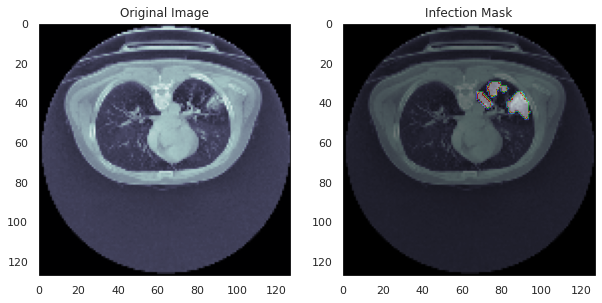

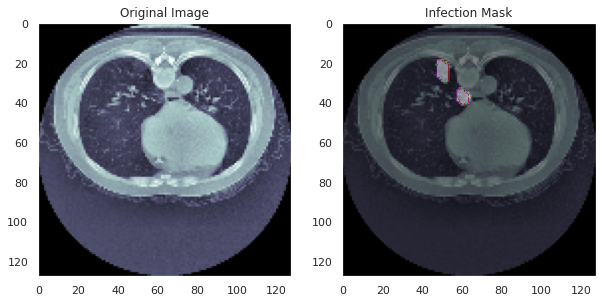

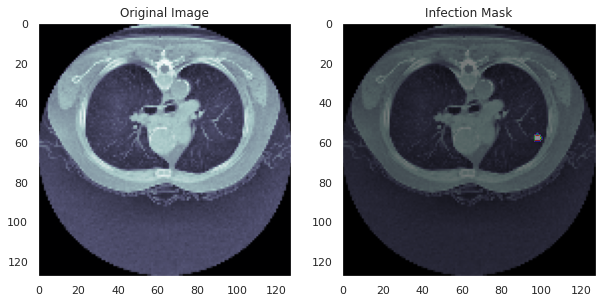

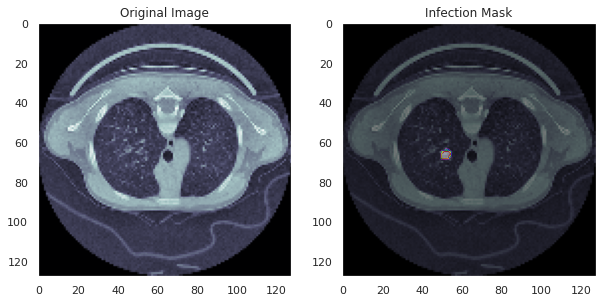

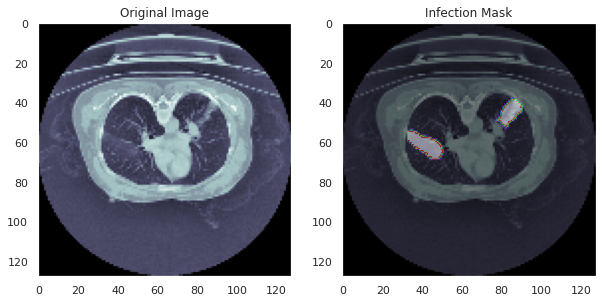

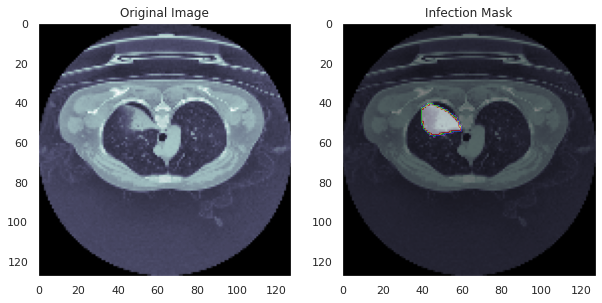

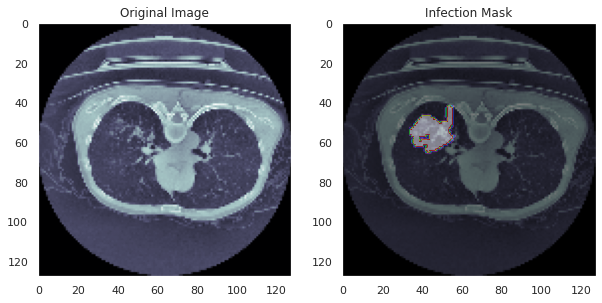

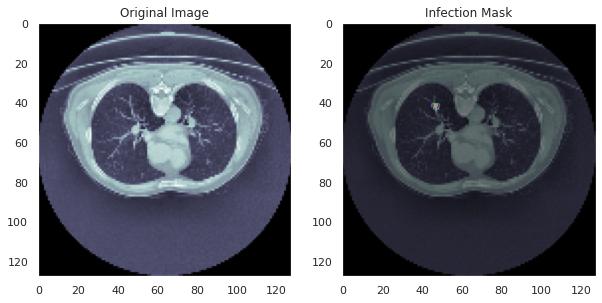

In [ ]:
for index in [90,110,120,135,140,150,170,180]:
    plot_processed_sample([cts[index], infections[index]])


In [ ]:
print(cts[1].min(),"min")
print(cts[1].max(),"max")
print(infections[1].min(),"min")
print(infections[1].max(),"max")
print(cts[1].shape)   
len(cts)
print(type(cts))
print(cts[1].shape)
# define the data augmentation method
sometimes = lambda aug: iaa.Sometimes(0.3, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.80, 1.5)),
    iaa.LinearContrast((0.90, 1.5)),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-30, 30), # rotate by -30 to +30 degrees
        ))
], random_order=True)

4 min
242 max
0 min
255 max
(128, 128)
<class 'numpy.ndarray'>
(128, 128)


In [ ]:
#generate imags of augmentation
no_of_aug_imgs = 200
random_indices = np.random.randint(0, cts.shape[0], size=no_of_aug_imgs)
sample_cts = cts[random_indices]
sample_inf = infections[random_indices]
ctsa, infa = seq(images=sample_cts, 
                              segmentation_maps=sample_inf)

In [ ]:
print(ctsa.shape, infa.shape)


(200, 128, 128) (200, 128, 128)


In [ ]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=10)

print(type(rand), len(rand))

<class 'numpy.ndarray'> 10


In [ ]:
cells1 = [ctsa[i] for i in rand]
cells2 = [infa[i] for i in rand]

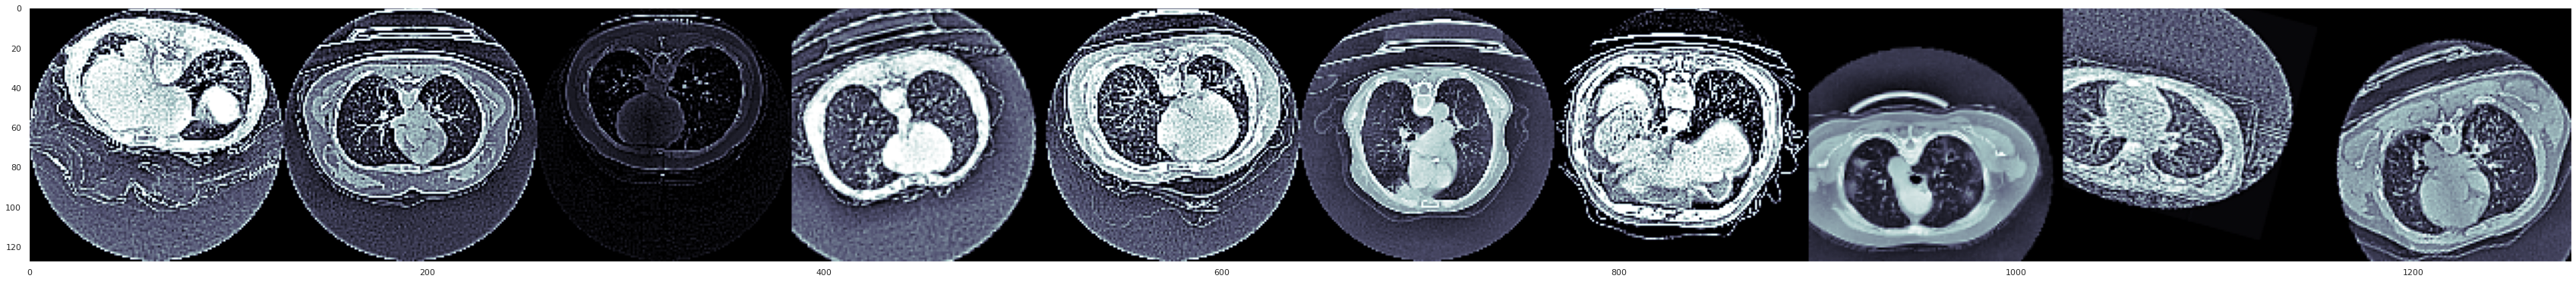

In [ ]:
# plot example of augmentation image and corresponding mask
grid_image1 = np.hstack(cells1)
plt.grid(False)
plt.imshow(grid_image1, cmap = 'bone')

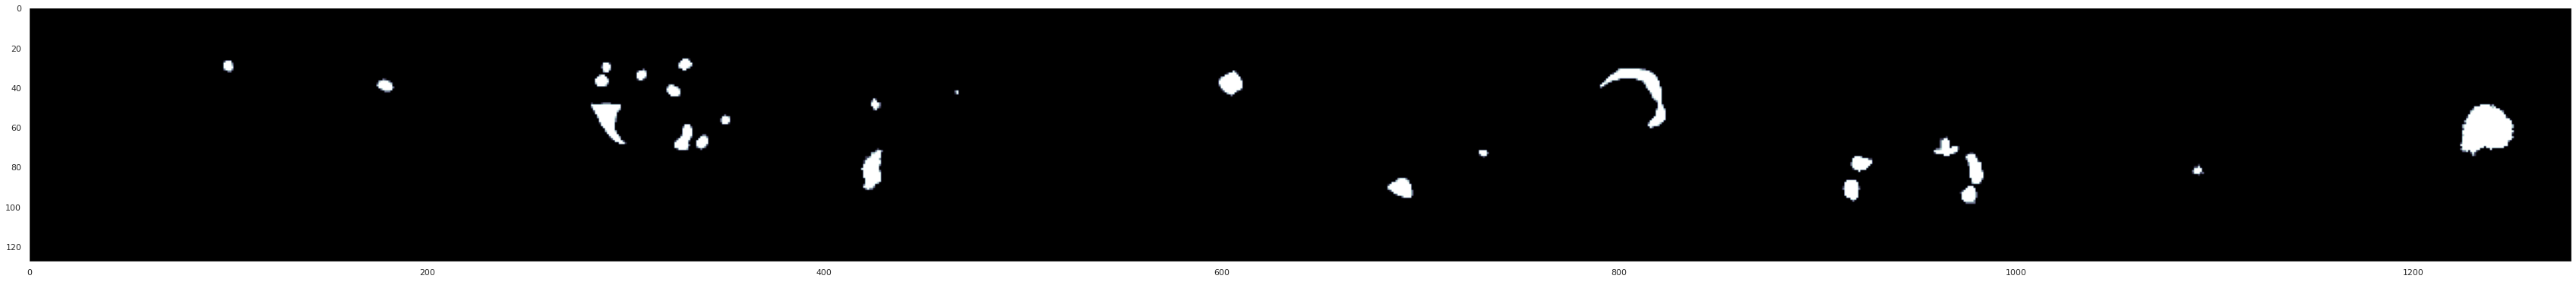

In [ ]:
grid_image2 = np.hstack(cells2)
plt.grid(False)
plt.imshow(grid_image2, cmap = 'bone')

In [ ]:
# concatenate the augmentation to training data set
cts = np.concatenate((cts, ctsa), axis=0)
infections = np.concatenate((infections, infa), axis = 0)
# np.random.shuffle(cts)
# np.random.shuffle(infections)
print(cts.shape, infections.shape)

(4224, 128, 128) (4224, 128, 128)


In [ ]:
print(cts.min())
print(cts.max())

0
255


In [ ]:
# normalize to (0,1)
cts=(cts-cts.min())/(cts.max()-cts.min())
infections=(infections-infections.min())/(infections.max()-infections.min())
print(cts.min())
print(cts.max())
print(infections.min())
print(infections.max())

0.0
1.0
0.0
1.0


In [ ]:
# reshape the images and corresponding mask to 128x128
cts = cts.reshape(len(cts), new_dim, new_dim, 1)
infections = infections.reshape(len(infections), new_dim, new_dim, 1)
print(len(cts), len(infections))
print(cts.shape, infections.shape)

4224 4224
(4224, 128, 128, 1) (4224, 128, 128, 1)


In [ ]:
# splict the dataset with 70% for training, and 30 % for validation
x_train,x_valid,y_train,y_valid=train_test_split(cts,infections,train_size=0.7,random_state=42)
print(x_train.shape, x_valid.shape)

(2956, 128, 128, 1) (1268, 128, 128, 1)


In [ ]:
# Basically we use the smooth to avoid division by 0.
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coeff(y_true, y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
# this function will used as loss function for training 
def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

        

### Create model || U-Net: Convolutional Networks for Biomedical Image Segmentation
the u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin

![official definiton](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
# define U-Net
inputs = Input((new_dim, new_dim, 1))

# contraction
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.4)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.4)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.4)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.4)(p4)
# ---------------------
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)
# ---------------------
# Expansion
u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
# set the batch size and epochs and the model name to be saved
batch_size = 32
epochs = 100
filepath_dice_coeff=root+"unet_covid_weights_dice_coeff.hdf5"
filepath_loss = root+"unet_covid_weights_val_loss.hdf5"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# training the model
model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
93/93 [==============================] - ETA: 0s - loss: 0.4304 - dice_coeff: 0.2289
Epoch 00001: val_dice_coeff improved from -inf to 0.00033, saving model to /gdrive/My Drive/COVID-19-20/COVID-19-20_v2/unet_covid_weights_dice_coeff.hdf5

Epoch 00001: val_loss improved from inf to 0.60801, saving model to /gdrive/My Drive/COVID-19-20/COVID-19-20_v2/unet_covid_weights_val_loss.hdf5
93/93 [==============================] - 39s 395ms/step - loss: 0.4304 - dice_coeff: 0.2289 - val_loss: 0.6080 - val_dice_coeff: 3.3104e-04
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.3144 - dice_coeff: 0.4294
Epoch 00002: val_dice_coeff improved from 0.00033 to 0.03188, saving model to /gdrive/My Drive/COVID-19-20/COVID-19-20_v2/unet_covid_weights_dice_coeff.hdf5

Epoch 00002: val_loss improved from 0.60801 to 0.53982, saving model to /gdrive/My Drive/COVID-19-20/COVID-19-20_v2/unet_covid_weights_val_loss.hdf5
93/93 [==============================] - 36s 387ms/step - l

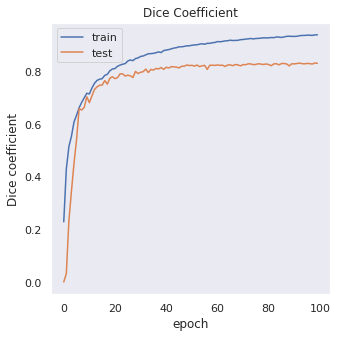

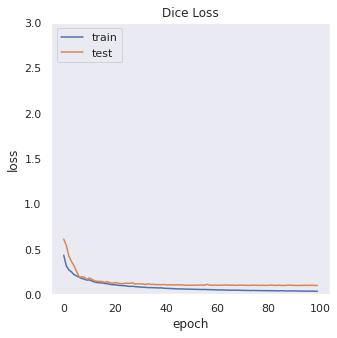

In [ ]:
# plot the training curve
rcParams['figure.figsize'] = 5, 5
plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.ylim(0, 3)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# define the function to compare the acutural image in validation set, ground truth mask and prediction mask 
plt.rcParams["axes.grid"] = False
def compare_actual_and_predicted(image_no):
    temp = model.predict(x_valid[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(x_valid[image_no].reshape(new_dim, new_dim),cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(y_valid[image_no].reshape(new_dim,new_dim))
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim))
    plt.title('Predicted mask')

    plt.show()
    

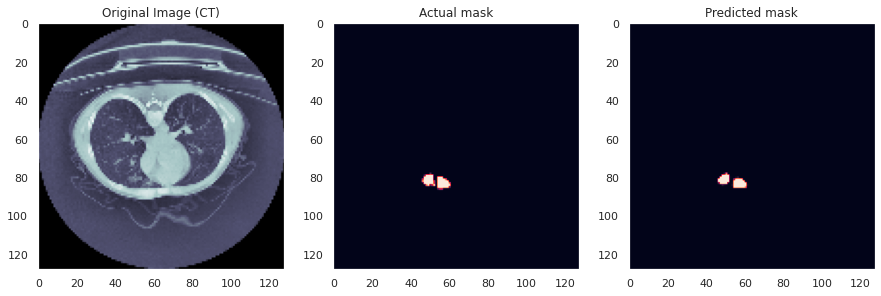

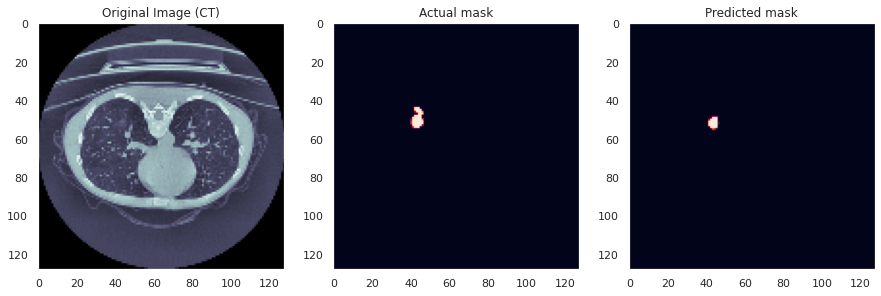

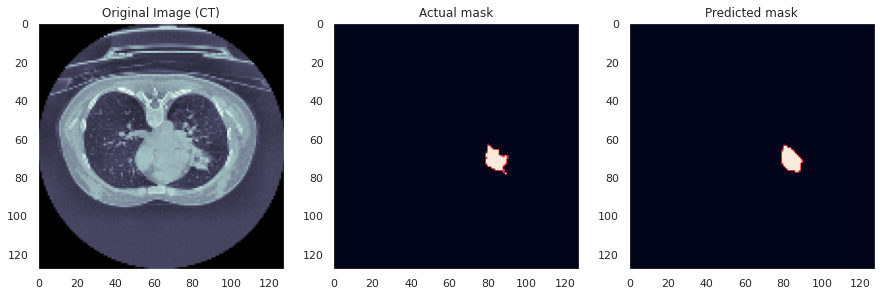

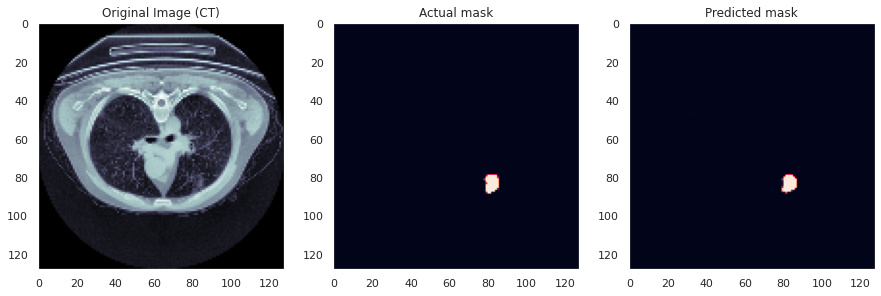

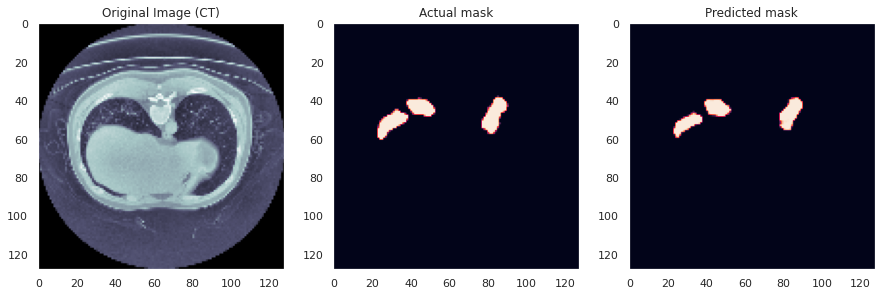

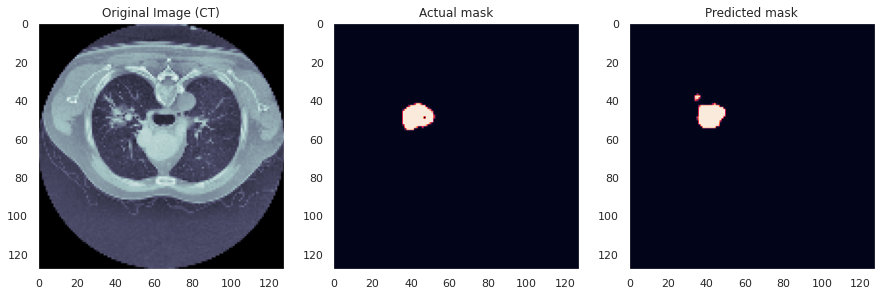

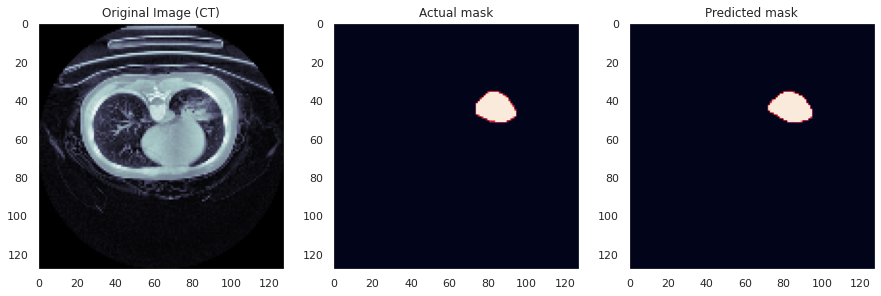

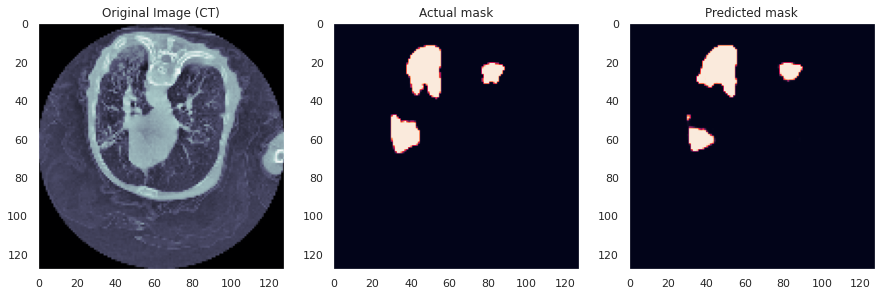

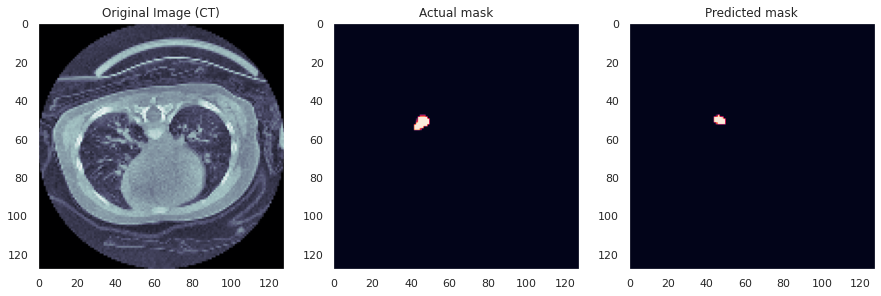

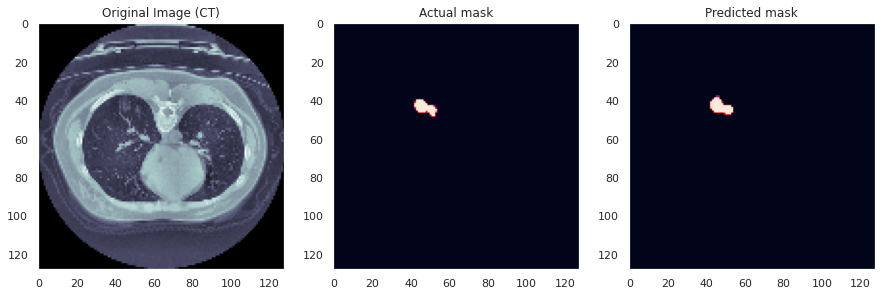

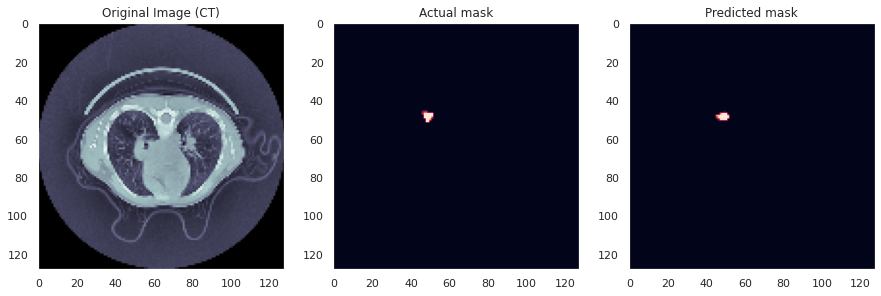

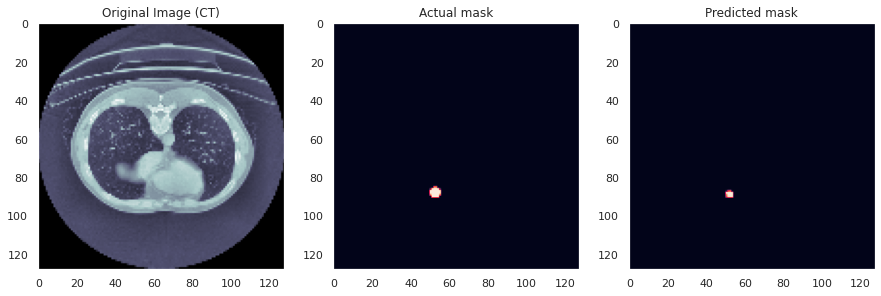

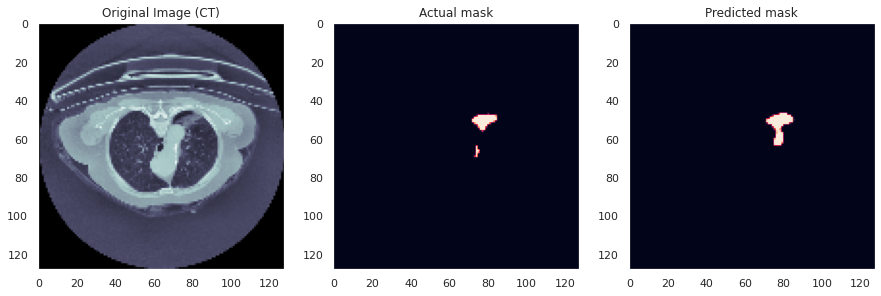

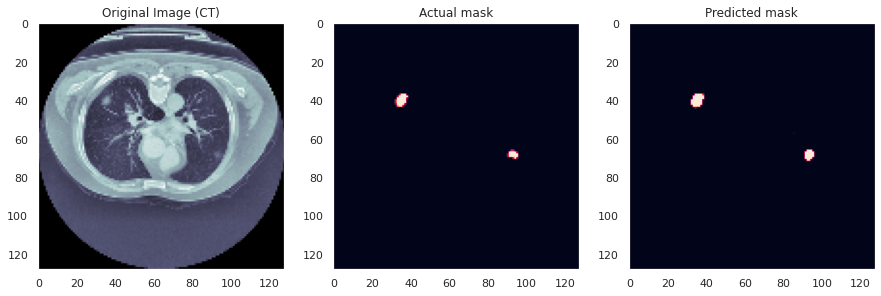

In [ ]:
# plot the some predition masks in validation data set
for i in [30,40,50,55,60,100,120,140,150,250,300,355, 380, 90]:
    compare_actual_and_predicted(i)

In [ ]:
# evaluate the result
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

40/40 [==============================] - 4s 107ms/step - loss: 0.0977 - dice_coeff: 0.8312
test loss, test dice coefficient: [0.09771016240119934, 0.831193745136261]


In [ ]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

40/40 [==============================] - 4s 106ms/step - loss: 0.0977 - dice_coeff: 0.8312
test loss, test dice coefficient: [0.09771016240119934, 0.831193745136261]


In [ ]:
threshold_range = np.arange(0.10,0.85, 0.05)
print(threshold_range)


[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8 ]


In [ ]:
dices=[]
ious=[]
#Testing for different Threshold values
for t in threshold_range:
  iou=sm.metrics.IOUScore(threshold=t)   # Returns:	A callable iou_score instance. Can be used in model.compile(...) function.
  dice = sm.metrics.FScore(threshold=t)  # Returns: A callable f_score instance. Can be used in model.compile(...) function.
  model.compile(optimizer=Adam(lr=0.0005),loss=bce_dice_loss,metrics=[dice,iou])
  score=model.evaluate(x_valid,y_valid,batch_size=32)
  dices.append(score[1])
  ious.append(score[2])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [==============================] - 5s 105ms/step - loss: 0.0977 - f1-score: 0.8306 - iou_score: 0.7115


In [ ]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", threshold_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.8331553339958191, 0.8331261873245239, 0.8331611752510071, 0.8330978155136108, 0.8330631256103516, 0.8328982591629028, 0.8327885866165161, 0.8326409459114075, 0.8324055671691895, 0.8321663737297058, 0.8319523930549622, 0.8317207098007202, 0.8314340710639954, 0.8310697674751282, 0.8306142091751099]
IOUS: [0.7151267528533936, 0.7151013612747192, 0.7151593565940857, 0.7150619029998779, 0.7150155901908875, 0.7147752046585083, 0.7146260142326355, 0.7144123911857605, 0.7140678763389587, 0.7137247920036316, 0.7134064435958862, 0.7130727171897888, 0.7126508951187134, 0.712128758430481, 0.7114626169204712]
Best Threshold: 0.20000000000000004
Best dice score: 0.8331611752510071
Best iou score: 0.7151593565940857


Best Threshold: 0.20000000000000004


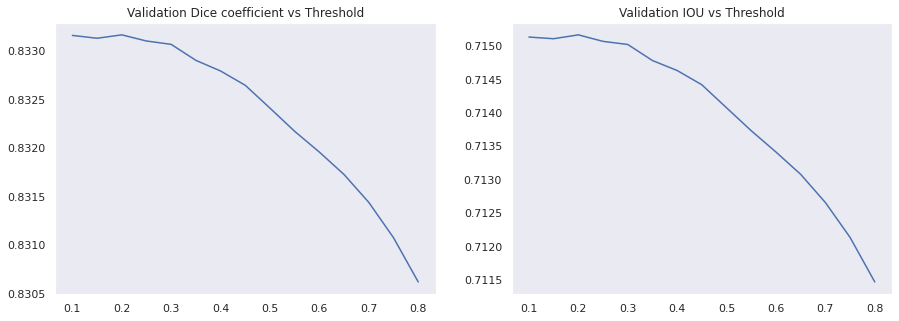

In [ ]:
print("Best Threshold:", threshold_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(threshold_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(threshold_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [ ]:
the_new_range = np.arange(0.18,0.23, 0.001)
new_dices=[]
new_ious=[]

for t in the_new_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  new_dices.append(score[1])
  new_ious.append(score[2])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [==============================] - 5s 106ms/step - loss: 0.0977 - f1-score: 0.8332 - iou_score: 0.7152


In [ ]:
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

New Best Threshold: 0.21500000000000002
Best new dice score: 0.8332235217094421
Best new iou score: 0.7152532339096069


Best Threshold: 0.21500000000000002


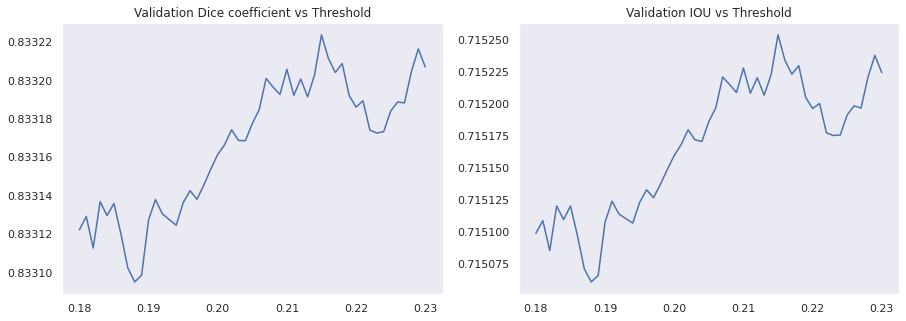

In [ ]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [ ]:
the_prec_rec_range = np.arange(0,1, 0.05)


In [ ]:
precisions=[]
recalls=[]
new_dices=[]

for t in the_prec_rec_range:
  precision = sm.metrics.Precision(threshold=t)
  recall = sm.metrics.Recall(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[precision, recall,dice])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  precisions.append(score[1])
  recalls.append(score[2])
  new_dices.append(score[3])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [==============================] - 5s 105ms/step - loss: 0.0977 - precision: 0.8902 - recall: 0.7737 - f1-score: 0.8270


In [ ]:
print("Best Threshold for dice:", the_prec_rec_range[np.argmax(new_dices)])
print("Best precision score:", precisions[np.argmax(new_dices)])
print("Best recall score:", recalls[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])

Best Threshold for dice: 0.2
Best precision score: 0.8547021150588989
Best recall score: 0.8140662908554077
Best new dice score: 0.8331611752510071


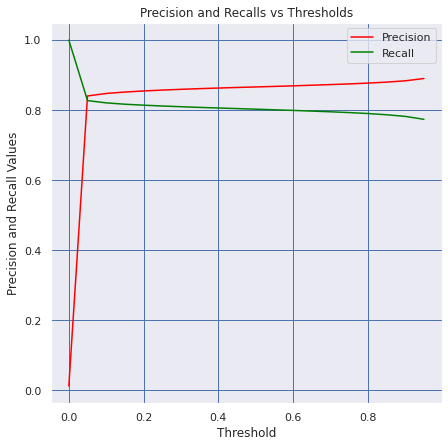

In [ ]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])

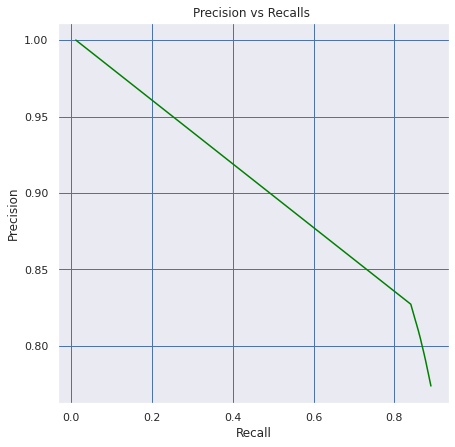

In [ ]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision vs Recalls ")
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.plot(recalls,precisions, color='red')
plt.plot(precisions, recalls, color='green')
# plt.legend(['Precision'])

In [ ]:
# read the data from validation data set

def read_nii_all(filepath,img_arr):

    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    # print(array.shape)
    slices = array.shape[2]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    
    for img_no in range(0, array.shape[0]):
      if (img_size !=array.shape[0]) or (img_size !=array.shape[1]):
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)  #resizing all images to the same dimensions
      else:
        img= array[img_no]
      # img=make_lungmask(img)
      xmax, xmin = img.max(), img.min()
      img = (img - xmin+1e-5)/(xmax - xmin+1e-5)        
      img = enhanced_img(img, visualize= 0)       
      img_arr.append(img)



50


In [ ]:
# make prediction for all the files in Validation and generate the masks
data = pd.read_excel('/gdrive/My Drive/COVID-19-20/COVID-19-20_v2/COVID-19-20_TrainValidation.xlsx',sheet_name = 'Validation set')
print(data.size)
data.head(5)
valid_root='/gdrive/My Drive/COVID-19-20/COVID-19-20_v2/Validation/'
test_root='/gdrive/My Drive/COVID-19-20/COVID-19-20_v2/test/'
prefix_len=len('volume-covid19-A-0')
for index in range(0, data.size):
  cts = []
  infections = []  
  read_nii_all(valid_root+data.loc[index,'FILENAME']+suffix, cts) 
  for i in range(0,len(cts)):
    cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)  
    temp = model.predict(cts[i].reshape(1,new_dim, new_dim, 1))
    temp=temp.reshape(new_dim,new_dim)
    infections.append(temp)
  infections = np.array(infections)
  # transform data into nii format
  infection_img_nii = nib.Nifti1Image(infections, affine=np.eye(4))
  nib.save(infection_img_nii, test_root+data.loc[index,'FILENAME'][prefix_len:]+'.nii.gz')
  